In [211]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
pwd

'/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy'

In [213]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata
import xeofs as xe
from geometry_izzyv1 import grad_sphere
from regression_izzyv1 import linregress_3D
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
import warnings
import os
warnings.filterwarnings('ignore')



In [214]:
# constant
rho_a = 1.225 # air density kg m-3
rho_w = 1000 #fresh water density kh m-3
rho_sw = 1027 # SW max density (https://essd.copernicus.org/articles/14/65/2022/essd-14-65-2022.pdf)

Cd_a = 1.5e-3 # drag coeff air
Cd_w = 5.5e-3 #drag coeff ice-water


In [215]:
gridtype = 'remapcon'

In [216]:
# dot dataset
path = '/Users/iw2g24/PycharmProjects/SSH_project/'
print(path)
ds = xr.open_dataset(path + 'Data/dot_all_30bmedian_goco05c_sig3_1.nc')
print(ds)
# ERA5 remap dataset
ds_era5 = xr.open_dataset(path + 'Data/ERA5_u10v10_Antartica_2000-2023_' + gridtype + '.nc')

/Users/iw2g24/PycharmProjects/SSH_project/
<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry 

<xarray.Dataset> Size: 65MB
Dimensions:                 (x: 321, y: 321, time: 52)
Coordinates:
  * x                       (x) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                       (y) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * time                    (time) object 416B 1978-01-01 12:00:00 ... 1978-1...
Data variables:
    crs                     int32 4B ...
    u                       (time, y, x) float32 21MB ...
    v                       (time, y, x) float32 21MB ...
    number_of_observations  (time, y, x) float32 21MB ...
    latitude                (y, x) float32 412kB ...
    longitude               (y, x) float32 412kB ...
Attributes:
    version:       4.1
    release_date:  April 2019
    Conventions:   CF-1.4
    citation:      Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhan...
    dataset_doi:   10.5067/INAWUWO7QH7B
<xarray.DataArray 'x' (x: 321)> Size: 3kB
array([-4010804.   , -3985736.475, -3960668.95 , ...,  3960668.95 ,
    

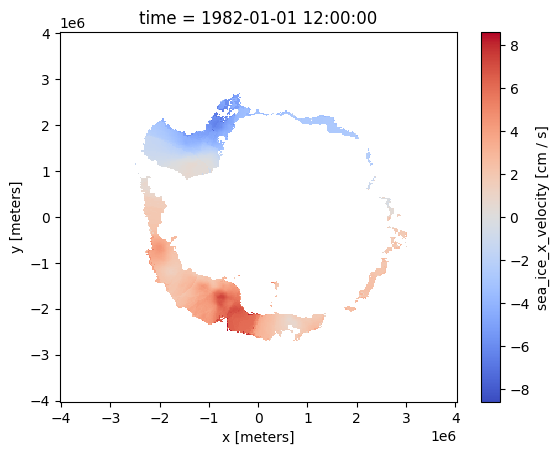

(321,)
(321,)


In [217]:
#sea ice drift data from nsidc
directory = "/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/si_drift_nsidc_v4/"
ds_example = xr.open_dataset(directory + 'icemotion_weekly_sh_25km_19781105_19781231_v4.1.nc')
print(ds_example)
print(ds_example['x'])

ds_example2 = xr.open_dataset(directory + 'icemotion_weekly_sh_25km_19820101_19821231_v4.1.nc')
print(ds_example2)
print(ds_example2['x'])

variable_name = "u"

# Extract the data array for plotting
data_to_plot = ds_example2[variable_name].isel(time=0)
print("plotted data size",data_to_plot.shape)

# Plot using xarray's built-in method
data_to_plot.plot(cmap="coolwarm")  # Replace 'viridis' with your preferred color map
#plt.title(f"{variable_name} at time {ds_example['time']}")
plt.show()

print(ds_example2["x"].shape)
print(ds_example2["y"].shape)

In [218]:
print(ds_example2["u"].attrs)

{'short_name': 'U', 'long_name': 'sea_ice_x_velocity', 'standard_name': 'sea_ice_x_velocity', 'units': 'cm / s', 'valid_min': -200.0, 'valid_max': 200.0, 'grid_mapping': 'crs', 'comment': 'U is the along-x component of the ice motion.  It is *not* the eastward velocity.'}


In [219]:
print(ds_example2.variables)


Frozen({'x': <xarray.IndexVariable 'x' (x: 321)> Size: 3kB
array([-4010804.   , -3985736.475, -3960668.95 , ...,  3960668.95 ,
        3985736.475,  4010804.   ])
Attributes:
    standard_name:          projection_x_coordinate
    coverage_content_type:  coordinate
    long_name:              x
    units:                  meters
    axis:                   X
    valid_min:              -4023337.7625
    valid_max:              4023337.7625, 'y': <xarray.IndexVariable 'y' (y: 321)> Size: 3kB
array([-4010804.   , -3985736.475, -3960668.95 , ...,  3960668.95 ,
        3985736.475,  4010804.   ])
Attributes:
    standard_name:          projection_y_coordinate
    coverage_content_type:  coordinate
    long_name:              y
    units:                  meters
    axis:                   Y
    valid_min:              -4023337.7625
    valid_max:              4023337.7625, 'time': <xarray.IndexVariable 'time' (time: 52)> Size: 416B
array([cftime.DatetimeJulian(1982, 1, 1, 12, 0, 0, 0, has_

In [220]:
ds_check = xr.open_dataset('si_drift_nsidc.nc')
print(ds_check)

<xarray.Dataset> Size: 5GB
Dimensions:                 (time: 2392, y: 321, x: 321)
Coordinates:
  * x                       (x) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                       (y) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * time                    (time) object 19kB 1978-01-01 12:00:00 ... 2023-1...
Data variables:
    crs                     (time) int32 10kB ...
    u                       (time, y, x) float32 986MB ...
    v                       (time, y, x) float32 986MB ...
    number_of_observations  (time, y, x) float32 986MB ...
    latitude                (time, y, x) float32 986MB ...
    longitude               (time, y, x) float32 986MB ...
Attributes:
    version:       4.1
    release_date:  April 2019
    Conventions:   CF-1.4
    citation:      Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhan...
    dataset_doi:   10.5067/INAWUWO7QH7B


In [221]:
ds_nsidc_drift = xr.open_dataset('si_drift_nsidc.nc')
print(ds_nsidc_drift)

<xarray.Dataset> Size: 5GB
Dimensions:                 (time: 2392, y: 321, x: 321)
Coordinates:
  * x                       (x) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                       (y) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * time                    (time) object 19kB 1978-01-01 12:00:00 ... 2023-1...
Data variables:
    crs                     (time) int32 10kB ...
    u                       (time, y, x) float32 986MB ...
    v                       (time, y, x) float32 986MB ...
    number_of_observations  (time, y, x) float32 986MB ...
    latitude                (time, y, x) float32 986MB ...
    longitude               (time, y, x) float32 986MB ...
Attributes:
    version:       4.1
    release_date:  April 2019
    Conventions:   CF-1.4
    citation:      Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhan...
    dataset_doi:   10.5067/INAWUWO7QH7B


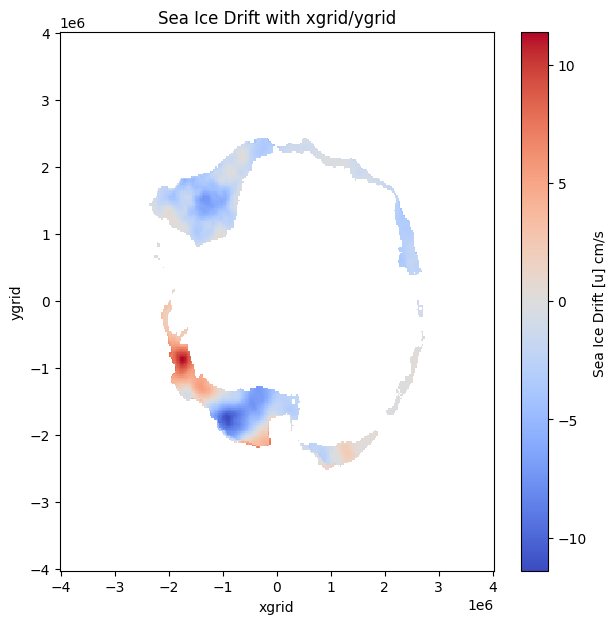

In [222]:
# Plot sea ice drift using x and y coordinates
data_to_plot = ds_nsidc_drift["u"]

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_nsidc_drift["x"],
    ds_nsidc_drift["y"],
    data_to_plot.isel(time=1156),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Drift [u] cm/s ")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("xgrid")
plt.ylabel("ygrid")
plt.show()


In [223]:
print("Data shape:", ds_nsidc_drift["u"].isel(time=1156).shape)
print("Longitude shape:", ds_nsidc_drift["longitude"].shape)
print("Latitude shape:", ds_nsidc_drift["latitude"].shape)


Data shape: (321, 321)
Longitude shape: (2392, 321, 321)
Latitude shape: (2392, 321, 321)


In [224]:
print(ds_nsidc_drift["longitude"])
print(ds_nsidc_drift["u"].values)

<xarray.DataArray 'longitude' (time: 2392, y: 321, x: 321)> Size: 986MB
[246474072 values with dtype=float32]
Coordinates:
  * x        (x) float64 3kB -4.011e+06 -3.986e+06 ... 3.986e+06 4.011e+06
  * y        (y) float64 3kB -4.011e+06 -3.986e+06 ... 3.986e+06 4.011e+06
  * time     (time) object 19kB 1978-01-01 12:00:00 ... 2023-12-24 12:00:00
Attributes:
    standard_name:  longitude
    units:          degrees_east
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan

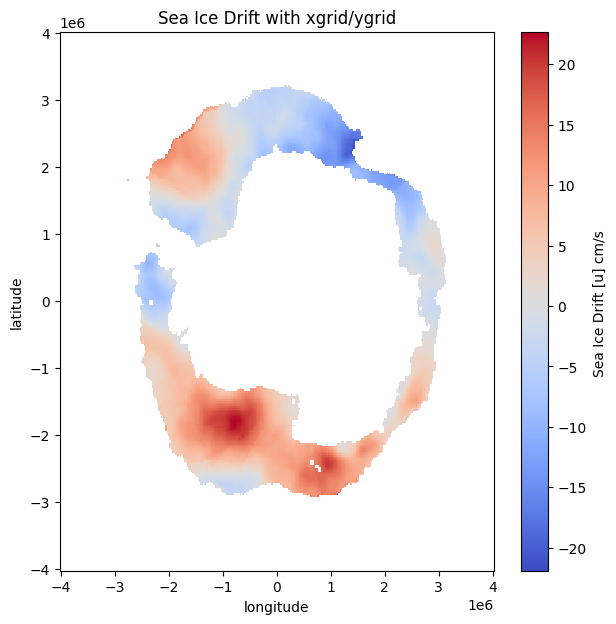

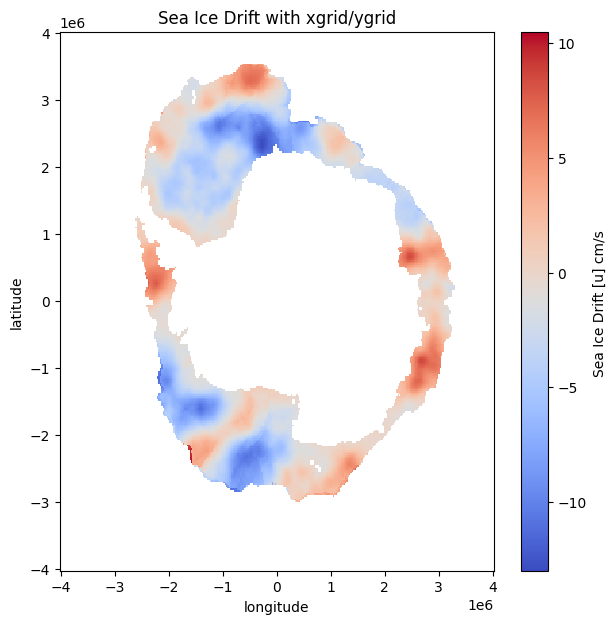

In [225]:
# Plot sea ice drift using x and y coordinates
data_to_plot = ds_nsidc_drift["u"]

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_nsidc_drift["x"],
    ds_nsidc_drift["y"],
    data_to_plot.isel(time=1115),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Drift [u] cm/s ")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_nsidc_drift["x"],
    ds_nsidc_drift["y"],
    data_to_plot.isel(time=2000),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Drift [u] cm/s ")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

In [226]:
print(ds_nsidc_drift["latitude"].dims)
print(ds_nsidc_drift["longitude"].dims)

('time', 'y', 'x')
('time', 'y', 'x')


In [227]:
print(ds_nsidc_drift.values)
print("Lon shape", ds_nsidc_drift['longitude'].shape)
print("Lat shape", ds_nsidc_drift['latitude'].shape)

# Compute the max and min values
lon_values = ds_nsidc_drift['longitude'].values  # Extract as a NumPy array
lon_max = np.max(lon_values)
lon_min = np.min(lon_values)

# Print the results
print(f"Longitude Min: {lon_min}, Longitude Max: {lon_max}")

<bound method Mapping.values of <xarray.Dataset> Size: 5GB
Dimensions:                 (time: 2392, y: 321, x: 321)
Coordinates:
  * x                       (x) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                       (y) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * time                    (time) object 19kB 1978-01-01 12:00:00 ... 2023-1...
Data variables:
    crs                     (time) int32 10kB ...
    u                       (time, y, x) float32 986MB nan nan nan ... nan nan
    v                       (time, y, x) float32 986MB ...
    number_of_observations  (time, y, x) float32 986MB ...
    latitude                (time, y, x) float32 986MB ...
    longitude               (time, y, x) float32 986MB ...
Attributes:
    version:       4.1
    release_date:  April 2019
    Conventions:   CF-1.4
    citation:      Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhan...
    dataset_doi:   10.5067/INAWUWO7QH7B>
Lon shape (2392, 321, 321)
Lat shape

In [228]:
print(ds_nsidc_drift["time"].dtype)

object


In [229]:
# Convert time to datetime64[ns] using astype()
ds_nsidc_drift["time"] = ds_nsidc_drift["time"].astype('datetime64[ns]')


In [230]:
print(ds_nsidc_drift["time"].dtype)
time_check = ds_nsidc_drift["time"].values
print(time_check)

datetime64[ns]
['1978-01-01T12:00:00.000000000' '1978-01-08T12:00:00.000000000'
 '1978-01-15T12:00:00.000000000' ... '2023-12-10T12:00:00.000000000'
 '2023-12-17T12:00:00.000000000' '2023-12-24T12:00:00.000000000']


In [231]:
time_nsidc_drift = ds_nsidc_drift['time'].values
print("nsidc drift time", time_nsidc_drift[1274],time_nsidc_drift[2119])

nsidc drift time 2002-07-02T12:00:00.000000000 2018-10-01T12:00:00.000000000


In [232]:
ds_check['u'].shape
ds_check['v'].shape

(2392, 321, 321)

In [233]:
5+5

10

In [234]:
# change coordinates from (lon,lat,time) to (time,lat,lon) as ERA5
lon_dot = ds['longitude'].values; lat_dot = ds['latitude'].values
dot_all = ds['dot'].values
dot = np.zeros((dot_all.shape[2], dot_all.shape[1], dot_all.shape[0]))
for t in range(0,dot_all.shape[2]):
    for i in range(0,dot_all.shape[1]):
        for j in range(0,dot_all.shape[0]):
            dot[t,i,j] = dot_all[j,i,t].copy()
seamask = dot[0].copy()/dot[0]
seamask[seamask == 0] = np.nan
del dot_all

In [235]:
# make lon lat 2d
llon = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[1]):
    llon[i,:] = lon_dot
llat = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[2]):
    llat[:,i] = lat_dot

In [236]:
print(dot.shape)
print(llon.shape)
print(llat.shape)
print(dot[0].shape)

(196, 64, 360)
(64, 360)
(64, 360)
(64, 360)


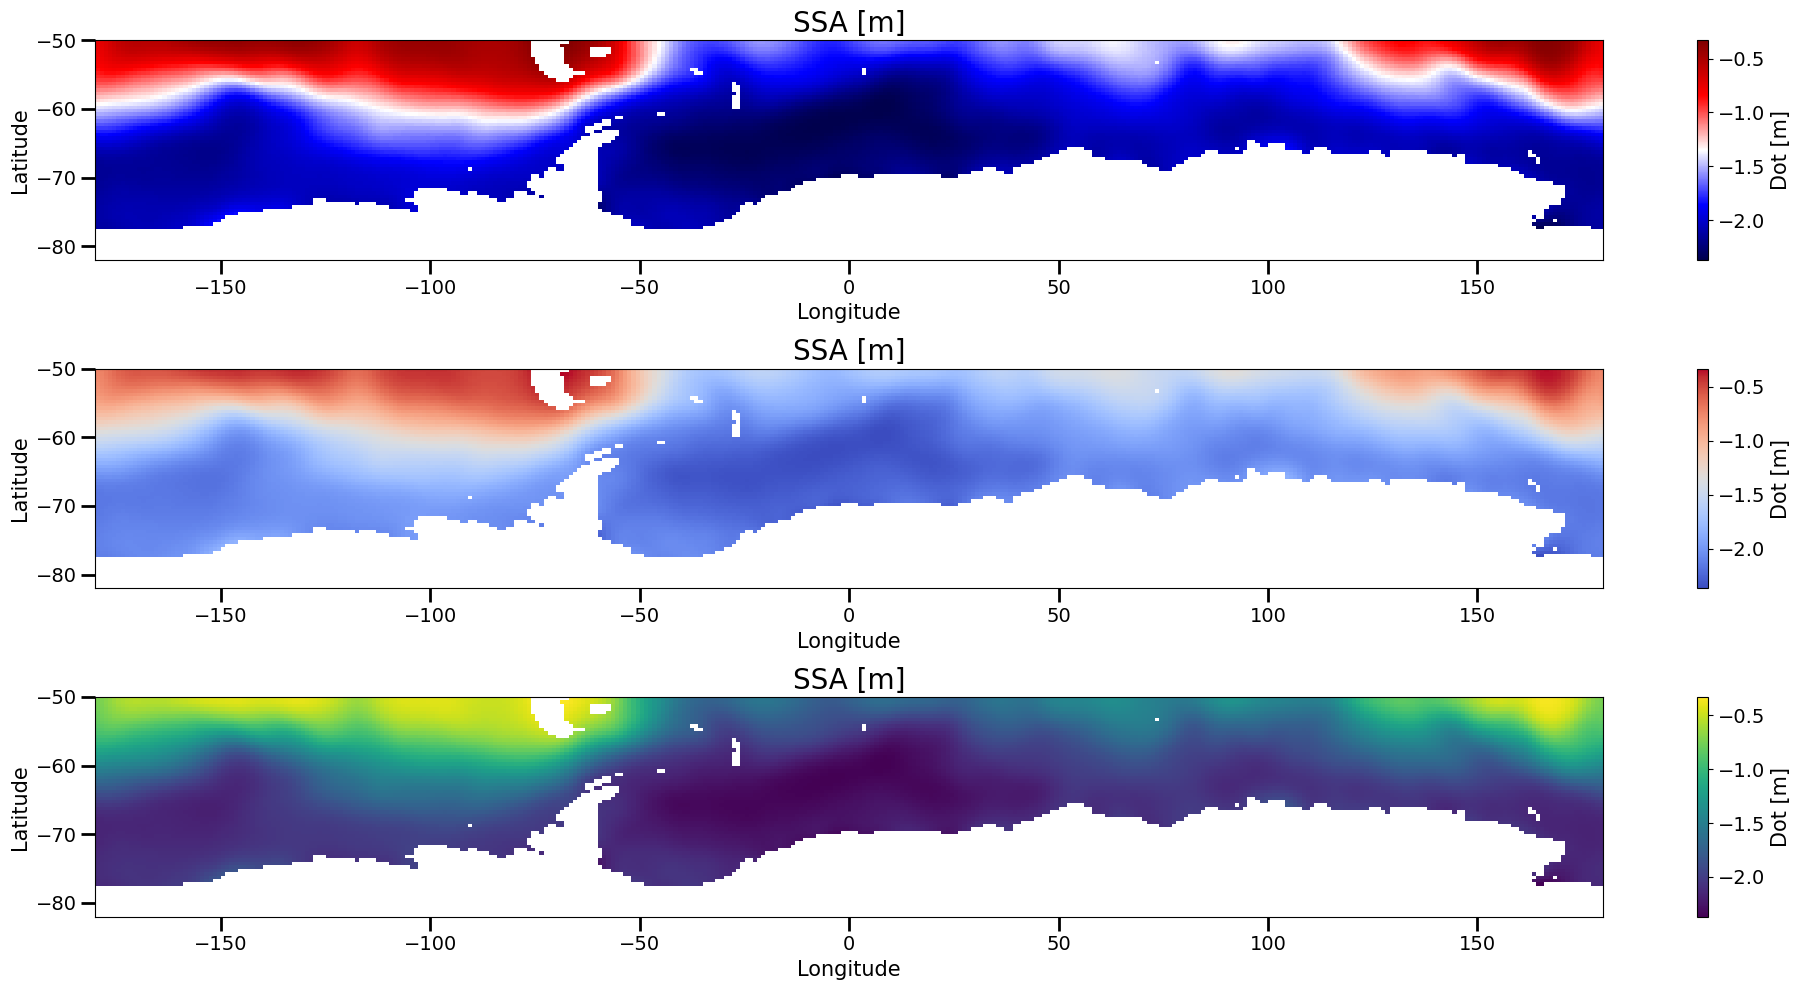

In [237]:
#plot dot with different colour schemes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

pc1 = axes[0].pcolormesh(llon,llat,dot[0], cmap='seismic')
axes[0].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[0].set_title('SSA [m]', fontsize=20)
axes[0].set_xlabel('Longitude', fontsize=15)
axes[0].set_ylabel('Latitude', fontsize=15)
cbar1 = fig.colorbar(pc1, ax=axes[0])
cbar1.set_label('Dot [m]', fontsize=15)
cbar1.ax.tick_params(labelsize=14)

pc2 = axes[1].pcolormesh(llon,llat,dot[0], cmap='coolwarm')
axes[1].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[1].set_title('SSA [m]', fontsize=20)
axes[1].set_xlabel('Longitude', fontsize=15)
axes[1].set_ylabel('Latitude', fontsize=15)
cbar2 = fig.colorbar(pc2, ax=axes[1])
cbar2.set_label('Dot [m]', fontsize=15)
cbar2.ax.tick_params(labelsize=14)

pc3 = axes[2].pcolormesh(llon,llat,dot[0], cmap='viridis')
axes[2].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[2].set_title('SSA [m]', fontsize=20)
axes[2].set_xlabel('Longitude', fontsize=15)
axes[2].set_ylabel('Latitude', fontsize=15)
cbar3 = fig.colorbar(pc3, ax=axes[2])
cbar3.set_label('Dot [m]', fontsize=15)
cbar3.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [238]:
# time
time_era5 = ds_era5['time'].values
time_dot = ds['time'].values
time_nsidc_drift = ds_nsidc_drift['time'].values

In [239]:
time_dot_array = np.array(time_dot, dtype='datetime64[ns]')
time_nsidc_array = np.array(time_nsidc_drift, dtype='datetime64[ns]')

indices_dot_nsidc = np.where(np.isin(time_nsidc_array, time_dot_array))
print(indices_dot_nsidc)

(array([], dtype=int64),)


In [240]:
#print(time_era5)
print("dot time", time_dot[0],time_dot[-1])
print("era5 time", time_era5[30],time_era5[225])
print("nsidc drift time", time_nsidc_drift[1274],time_nsidc_drift[2119])

print(225-30)
2219-1274

dot time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
era5 time 2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
nsidc drift time 2002-07-02T12:00:00.000000000 2018-10-01T12:00:00.000000000
195


945

In [241]:
print(type(ds_nsidc_drift.indexes['time']))  # Should show CFTimeIndex

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [242]:
# Check the time index type
print(type(ds_nsidc_drift.indexes['time']))  # Should show CFTimeIndex

# Check the type of the current time index
if isinstance(ds_nsidc_drift.indexes['time'], xr.CFTimeIndex):
    print("Converting CFTimeIndex to DatetimeIndex...")

    # Convert CFTimeIndex to DatetimeIndex
    datetimeindex = ds_nsidc_drift.indexes['time'].to_datetimeindex()

    # Replace the time coordinate with the new DatetimeIndex
    ds_nsidc_drift = ds_nsidc_drift.assign_coords(time=datetimeindex)

    # Verify the new time coordinate type
    print("Updated time index type:", type(ds_nsidc_drift.indexes['time']))  # Should now show DatetimeIndex
    print("Updated time coordinate values:")
    print(ds_nsidc_drift['time'])
else:
    print("The time index is already a DatetimeIndex or incompatible type.")
    print("Current time index type:", type(ds_nsidc_drift.indexes['time']))



<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
The time index is already a DatetimeIndex or incompatible type.
Current time index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [243]:
import pandas as pd
import xarray as xr

# Convert the time coordinate to pandas DatetimeIndex
time_index = pd.to_datetime(ds_nsidc_drift['time'].values)

# Extract latitude and longitude at the first time step (removing time dependency)
latitude = ds_nsidc_drift['latitude'].isel(time=0)
longitude = ds_nsidc_drift['longitude'].isel(time=0)

# Lists to store the first date of each month and the averages
monthly_averages_u = []
monthly_averages_v = []
new_month = []

# Iterate through the datetime array to group by month
for current_month in time_index.to_period('M').unique():  # Loop through each unique month
    # Get the indices for the current month
    month_mask = time_index.to_period('M') == current_month

    # Select the data for the current month and average across time
    monthly_u = ds_nsidc_drift['u'][month_mask].mean(dim='time')  # Average u
    monthly_v = ds_nsidc_drift['v'][month_mask].mean(dim='time')  # Average v

    # Store the monthly averages
    monthly_averages_u.append(monthly_u)
    monthly_averages_v.append(monthly_v)

    # Store the first date of the current month (arbitrary time step)
    new_month.append(current_month.start_time)

# Create a new time coordinate with the first of each month
new_time = pd.to_datetime(new_month)

# Create new xarray DataArrays for the averaged u and v values
monthly_avg_u = xr.DataArray(
    monthly_averages_u,
    dims=("time", "y", "x"),
    coords={
        "time": new_time,
        "latitude": latitude,  # Use fixed latitude without time dimension
        "longitude": longitude,  # Use fixed longitude without time dimension
    },
    name="u",  # Keeping the original name for u
)

monthly_avg_v = xr.DataArray(
    monthly_averages_v,
    dims=("time", "y", "x"),
    coords={
        "time": new_time,
        "latitude": latitude,  # Use fixed latitude without time dimension
        "longitude": longitude,  # Use fixed longitude without time dimension
    },
    name="v",  # Keeping the original name for v
)

# Create a new Dataset with both monthly average u and v
subset_ds = xr.Dataset(
    {
        "u": monthly_avg_u,  # Storing monthly averaged u
        "v": monthly_avg_v,  # Storing monthly averaged v
    }
)

# Verify the new dataset
print(subset_ds)


<xarray.Dataset> Size: 456MB
Dimensions:    (time: 552, y: 321, x: 321)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1978-01-01 1978-02-01 ... 2023-12-01
    latitude   (y, x) float32 412kB -37.14 -37.31 -37.49 ... -37.31 -37.14
    longitude  (y, x) float32 412kB -135.0 -135.2 -135.4 ... 44.64 44.82 45.0
Dimensions without coordinates: y, x
Data variables:
    u          (time, y, x) float32 228MB nan nan nan nan ... nan nan nan nan
    v          (time, y, x) float32 228MB nan nan nan nan ... nan nan nan nan


In [244]:
print(ds_nsidc_drift.dims)
print(ds_nsidc_drift.coords)
print(ds_nsidc_drift.var)

print(subset_ds.dims)
print(subset_ds.coords)
print(subset_ds.var)

FrozenMappingWarningOnValuesAccess({'time': 2392, 'y': 321, 'x': 321})
Coordinates:
  * x        (x) float64 3kB -4.011e+06 -3.986e+06 ... 3.986e+06 4.011e+06
  * y        (y) float64 3kB -4.011e+06 -3.986e+06 ... 3.986e+06 4.011e+06
  * time     (time) datetime64[ns] 19kB 1978-01-01T12:00:00 ... 2023-12-24T12...
<bound method DatasetAggregations.var of <xarray.Dataset> Size: 5GB
Dimensions:                 (time: 2392, y: 321, x: 321)
Coordinates:
  * x                       (x) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                       (y) float64 3kB -4.011e+06 -3.986e+06 ... 4.011e+06
  * time                    (time) datetime64[ns] 19kB 1978-01-01T12:00:00 .....
Data variables:
    crs                     (time) int32 10kB ...
    u                       (time, y, x) float32 986MB nan nan nan ... nan nan
    v                       (time, y, x) float32 986MB ...
    number_of_observations  (time, y, x) float32 986MB ...
    latitude                (time, y, x) fl

In [245]:
first_dates_array_formatted = pd.Series(subset_ds['time'].values)

In [246]:
time_dot_array = np.array(time_dot, dtype='datetime64[ns]')
#time_nsidc_array = np.array(first_dates_array_formatted, dtype='datetime64[ns]')
time_subset_array = np.array(subset_ds['time'], dtype='datetime64[ns]')

indices_dot_nsidc = np.where(np.isin(time_subset_array, time_dot_array))
print(indices_dot_nsidc)
#print(time_era5)
print("dot time", time_dot[0], time_dot[-1])
print("era5 time", time_era5[30], time_era5[225])
print("nsidc drift time", first_dates_array_formatted[294], first_dates_array_formatted[489])

print(225 - 30)
489-294

(array([294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
       333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
       359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371,
       372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384,
       385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397,
       398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410,
       411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423,
       424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
       437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449,
       450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 4

195

In [247]:
tstart_era5 = 30
tend_era5 = 226 # +1 respect cell above

tstart_nsidc = 294
tend_nsidc = 490 #+1 respect cell above

In [248]:
# select sea ice drift u
#seaice_drift_u = ds_nsidc_drift['u'][tstart_nsidc:tend_nsidc].values
seaice_drift_u = subset_ds['u'][tstart_nsidc:tend_nsidc].values
print(seaice_drift_u.shape)
print(seaice_drift_u)

# select sea ice drift v
#seaice_drift_v = ds_nsidc_drift['v'][tstart_nsidc:tend_nsidc].values
seaice_drift_v = subset_ds['v'][tstart_nsidc:tend_nsidc].values
print(seaice_drift_v.shape)
print(seaice_drift_v)

(196, 321, 321)
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan n

In [249]:
print(seaice_drift_u.shape)
print(seamask.shape)

(196, 321, 321)
(64, 360)


In [250]:
# DE-TREND DOT

In [251]:
# linear regression in time on each grid point
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot)
# remove trend for dot
xt = np.zeros(dot.shape)
for t in range(0,dot.shape[0]):
    xt[t] = t
dot_detrended = dot - (slope*xt + intercept)

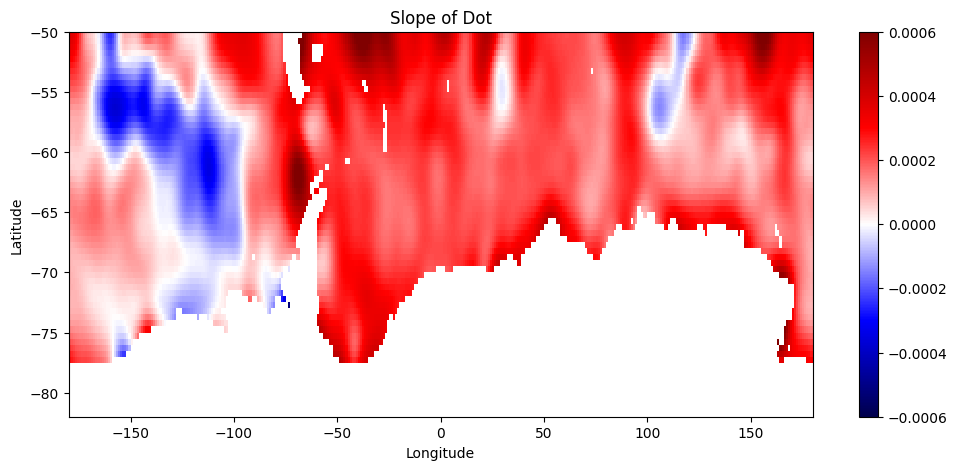

In [252]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope, vmin=-6e-4, vmax=6e-4, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Dot')
plt.colorbar()


In [253]:
dot_final = dot_detrended.copy()

In [254]:
seaice_u = subset_ds['u'][tstart_nsidc:tend_nsidc].values
seaice_v = subset_ds['v'][tstart_nsidc:tend_nsidc].values

print(seaice_u.shape)
print(seaice_v.shape)

# Assuming 'time_new' is the time coordinate in the dataset
time_values = subset_ds['time'][tstart_nsidc:tend_nsidc].values
print(time_values.shape)  # To verify the shape
#print(time_values)


(196, 321, 321)
(196, 321, 321)
(196,)


In [255]:
print(seaice_u.shape)
print((seaice_u).shape[0])
print((seaice_u[0]).shape)


(196, 321, 321)
196
(321, 321)


In [256]:

lat_nsidc_drift = subset_ds['latitude'].values  # Shape (time,y, x)
lon_nsidc_drift = subset_ds['longitude'].values # Shape (time,y, x)

print(lon_nsidc_drift.shape)
print(lat_nsidc_drift.shape)

(321, 321)
(321, 321)


In [257]:
print(seaice_drift_u.shape)
print(seaice_drift_u[0].shape)
print(seaice_u.shape[0])

print(seaice_drift_u.shape)
print((seaice_drift_u).shape[0])

(196, 321, 321)
(321, 321)
196
(196, 321, 321)
196


In [258]:
#remap data onto dot grid
# Target grid
lon_target = ds['longitude'].values  # (360,)
lat_target = ds['latitude'].values  # (64,)

# Create an empty list to store regridded data
regridded_data_u = []
regridded_data_v = []
time_steps_list = []


# Loop through each time step of the original sea ice data
for t in range(seaice_drift_u.shape[0]):  # Loop over the time dimension
    # Extracting the sea ice concentration at time t, shape (321, 321)
    seaice_u = seaice_drift_u[t]
    seaice_v = seaice_drift_v[t]

    # Coordinates for the original grid
    lon_seaice = lon_nsidc_drift  # (321, 321)
    lat_seaice = lat_nsidc_drift  # (321, 321)

    # Flatten original grid and sea ice data
    points = np.array([lon_seaice.flatten(), lat_seaice.flatten()]).T  # [lon, lat]
    values_u = seaice_u.flatten()
    values_v = seaice_v.flatten()

    # print(points.shape)
    # print(values.shape)

    # Generate target grid (meshgrid for lon and lat)
    lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)  # 2D target grid

    # Interpolate onto the target grid
    seaice_regridded_u = griddata(points, values_u, (lon_mesh, lat_mesh), method='linear')
    seaice_regridded_v = griddata(points, values_v, (lon_mesh, lat_mesh), method='linear')

    # Add regridded data to list (append 2D array for this time step)
    regridded_data_u.append(seaice_regridded_u)
    regridded_data_v.append(seaice_regridded_v)

    # Store the corresponding time value
    time_steps_list.append(time_values[t])  # Add the corresponding time step

# Stack the regridded data along the time dimension
regridded_seaice_drift_u = np.stack(regridded_data_u, axis=0)  # Shape: (time, lat, lon)
regridded_seaice_drift_v = np.stack(regridded_data_v, axis=0)

# Now you can use regridded_data, and time_steps_list to refer to the time dimension
print(f"Regridded data shape u: {regridded_seaice_drift_u.shape}")
print(f"Regridded data shape v: {regridded_seaice_drift_u.shape}")
#print(f"Time steps: {time_steps_list}")


Regridded data shape u: (196, 64, 360)
Regridded data shape v: (196, 64, 360)


In [259]:
# Create new xarray DataArrays for regridded 'u' and 'v' data
regridded_seaice_da_u = xr.DataArray(
    regridded_seaice_drift_u,
    dims=("time", "lat", "lon"),
    coords={
        "time": time_steps_list,  # Time steps (list of datetime objects)
        "lat": lat_target,  # New latitude grid (64,)
        "lon": lon_target,  # New longitude grid (360,)
    },
    name="seaice_drift_u",  # Variable name for 'u'
)

regridded_seaice_da_v = xr.DataArray(
    regridded_seaice_drift_v,
    dims=("time", "lat", "lon"),
    coords={
        "time": time_steps_list,  # Time steps (list of datetime objects)
        "lat": lat_target,  # New latitude grid (64,)
        "lon": lon_target,  # New longitude grid (360,)
    },
    name="seaice_drift_v",  # Variable name for 'v'
)

# Create a single Dataset with both regridded DataArrays
regridded_seaice_ds = xr.Dataset(
    {
        "seaice_drift_u": regridded_seaice_da_u,
        "seaice_drift_v": regridded_seaice_da_v,
    }
)

# Print dataset to verify
print(regridded_seaice_ds)



<xarray.Dataset> Size: 72MB
Dimensions:         (time: 196, lat: 64, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat             (lat) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * lon             (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    seaice_drift_u  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan
    seaice_drift_v  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan


<xarray.Dataset> Size: 72MB
Dimensions:         (time: 196, lat: 64, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat             (lat) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * lon             (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    seaice_drift_u  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan
    seaice_drift_v  (time, lat, lon) float64 36MB nan nan nan ... nan nan nan


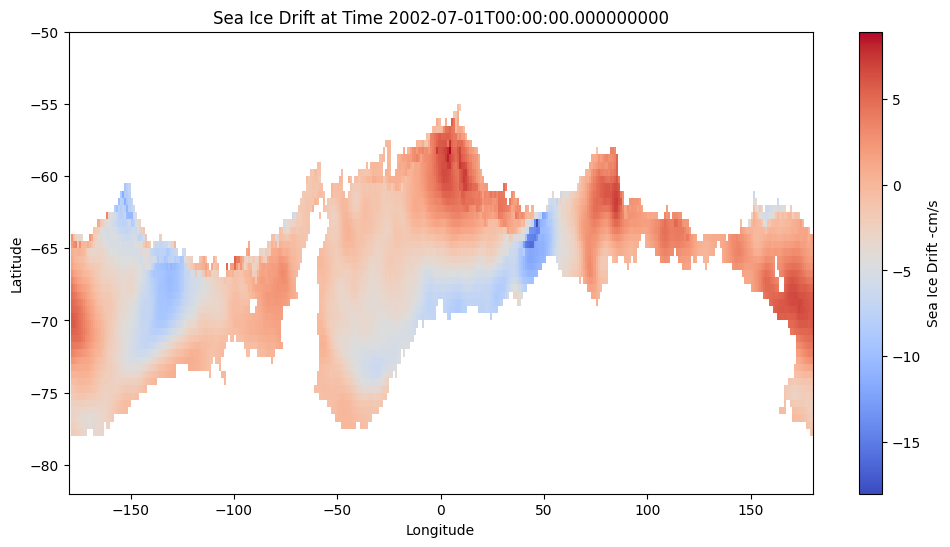

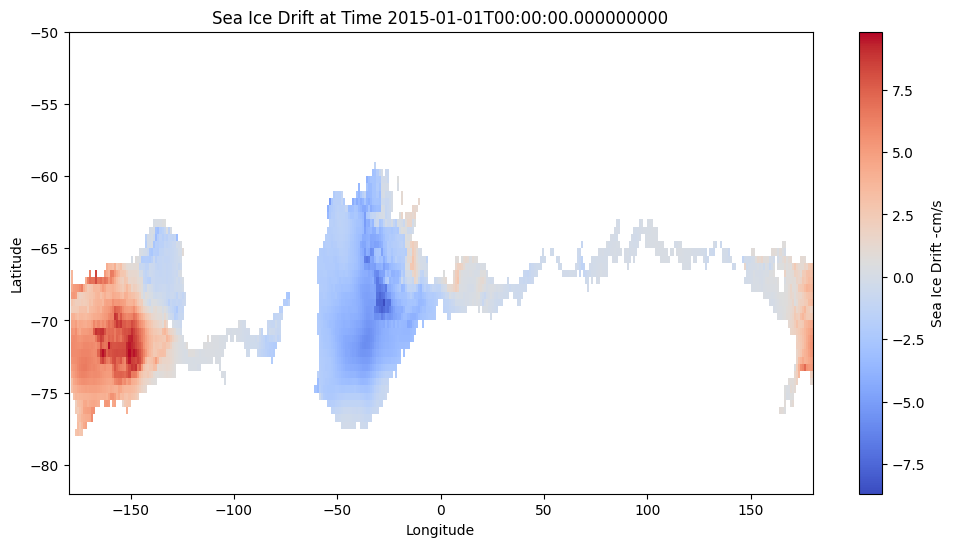

In [260]:
print(regridded_seaice_ds)

# Extract the time, latitude, and longitude coordinates
time_values = regridded_seaice_ds['time'].values
lat_values = regridded_seaice_ds['lat'].values
lon_values = regridded_seaice_ds['lon'].values
time_step = 0

# Create a meshgrid for lat/lon coordinates for plotting
lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)

# Plot the sea ice concentration at time step 0 (you can change the time index)
plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_ds['seaice_drift_u'].isel(time=time_step), cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Drift -cm/s')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Drift at Time {time_values[0]}')  # Use time label for title
plt.show()

plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_ds['seaice_drift_u'].isel(time=150), cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Drift -cm/s')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Drift at Time {time_values[150]}')  # Use time label for title
plt.show()

In [261]:
time_step = 0
# Select the data at the specified time step
seaice_drift_u_at_time = regridded_seaice_ds['seaice_drift_u'].isel(time=time_step)
seaice_drift_v_at_time = regridded_seaice_ds['seaice_drift_v'].isel(time=time_step)

# Create the ice mask by dividing by itself and setting zeros to NaN
icemask_u = seaice_drift_u_at_time / seaice_drift_u_at_time
icemask_u = icemask_u.where(icemask_u != 0, np.nan)  # Replace zeros with NaN

icemask_v = seaice_drift_v_at_time / seaice_drift_v_at_time
icemask_v = icemask_v.where(icemask_v != 0, np.nan)  # Replace zeros with NaN



In [262]:
#apply the icemask
# Apply the masks to the u and v components across the entire time dimension
seaice_masked_u = regridded_seaice_ds['seaice_drift_u'] * icemask_u
seaice_masked_v = regridded_seaice_ds['seaice_drift_v'] * icemask_v

# Create a new dataset with masked values
seaice_drift_masked_ds = xr.Dataset(
    {
        'seaice_drift_u_masked': seaice_masked_u,
        'seaice_drift_v_masked': seaice_masked_v
    },
    coords=regridded_seaice_ds.coords
)

# Print the resulting dataset to verify
print(seaice_drift_masked_ds)

<xarray.Dataset> Size: 72MB
Dimensions:                (time: 196, lat: 64, lon: 360)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * lat                    (lat) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * lon                    (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
Data variables:
    seaice_drift_u_masked  (time, lat, lon) float64 36MB nan nan nan ... nan nan
    seaice_drift_v_masked  (time, lat, lon) float64 36MB nan nan nan ... nan nan


In [263]:
U = np.sqrt(seaice_masked_u**2. + seaice_masked_v**2.)
print(U.shape)

(196, 64, 360)


In [264]:
#calculate sea ice drift stress
tau_x = rho_sw*Cd_w*U*seaice_masked_u #zonal drift stress
tau_y = rho_sw*Cd_w*U*seaice_masked_v #meridional drift stress

print(tau_x.shape)
print(llon.shape)



(196, 64, 360)
(64, 360)


In [265]:
#calculate sea ice drift curl
sid_curl = np.zeros(tau_x.shape)

for t in range(0, dot.shape[0]):
    dtaux_dx, dtaux_dy = grad_sphere(tau_x[t], llon, llat)
    dtauy_dx, dtauy_dy = grad_sphere(tau_y[t], llon, llat)
    sid_curl[t] = dtauy_dx - dtaux_dy

In [266]:
# Detrend sea ice drift components (u and v)

# Extract the sea ice drift components
seaice_drift_u = regridded_seaice_ds['seaice_drift_u']
seaice_drift_v = regridded_seaice_ds['seaice_drift_v']

# Linear regression in time on each grid point for 'u'
n_si_u, slope_si_u, intercept_si_u, p_val_si_u, r_square_si_u, rmse_si_u = linregress_3D(seaice_drift_u)
# Linear regression in time on each grid point for 'v'
n_si_v, slope_si_v, intercept_si_v, p_val_si_v, r_square_si_v, rmse_si_v = linregress_3D(seaice_drift_v)

# Remove trend for 'u'
xt_si = np.zeros(seaice_drift_u.shape)
for t in range(0, seaice_drift_u.shape[0]):
    xt_si[t] = t

seaice_drift_u_detrended = seaice_drift_u - (slope_si_u * xt_si + intercept_si_u)
seaice_drift_v_detrended = seaice_drift_v - (slope_si_v * xt_si + intercept_si_v)

# Squeeze slopes to remove singleton dimensions
slope_si_u = slope_si_u.squeeze()
slope_si_v = slope_si_v.squeeze()

# Verify shapes
print("Longitude shape:", lon_mesh.shape)
print("Latitude shape:", lat_mesh.shape)
print("Data shape (slope_si_u):", slope_si_u.shape)
print("Data shape (slope_si_v):", slope_si_v.shape)

Longitude shape: (64, 360)
Latitude shape: (64, 360)
Data shape (slope_si_u): (64, 360)
Data shape (slope_si_v): (64, 360)


In [267]:
print('slope v range: ', slope_si_v.min(), slope_si_v.max(), slope_si_v.mean(), slope_si_v.std())
print('slope u range: ', slope_si_u.min(), slope_si_u.max(), slope_si_u.mean(), slope_si_u.std())

print('seaice drift u range:', seaice_drift_u.min(), seaice_drift_u.max())
print('seaice drift v range:', seaice_drift_v.min(), seaice_drift_v.max())


slope v range:  nan nan nan nan
slope u range:  nan nan nan nan
seaice drift u range: <xarray.DataArray 'seaice_drift_u' ()> Size: 8B
array(-29.32073657) <xarray.DataArray 'seaice_drift_u' ()> Size: 8B
array(27.16314453)
seaice drift v range: <xarray.DataArray 'seaice_drift_v' ()> Size: 8B
array(-23.26707275) <xarray.DataArray 'seaice_drift_v' ()> Size: 8B
array(28.42704008)


In [268]:
temporal_variance_u = seaice_drift_u.var(axis=0)
temporal_variance_v = seaice_drift_v.var(axis=0)

print("Number of grid points with zero variance in u:", (temporal_variance_u == 0).sum())
print("Number of grid points with zero variance in v:", (temporal_variance_v == 0).sum())
print('number of grid point u: ', seaice_drift_u.size)
print('number of grid point v: ', seaice_drift_v.size)


Number of grid points with zero variance in u: <xarray.DataArray 'seaice_drift_u' ()> Size: 8B
array(195)
Number of grid points with zero variance in v: <xarray.DataArray 'seaice_drift_v' ()> Size: 8B
array(195)
number of grid point u:  4515840
number of grid point v:  4515840


In [269]:
#detrend seaice drift for masked ds

seaice_drift_u_masked = seaice_drift_masked_ds['seaice_drift_u_masked']
seaice_drift_v_masked = seaice_drift_masked_ds['seaice_drift_v_masked']

# Linear regression in time on each grid point for 'u'
n_si_u_mask, slope_si_u_mask, intercept_si_u_mask, p_val_si_u_mask, r_square_si_u_mask, rmse_si_u_mask = linregress_3D(seaice_drift_u_masked)
# Linear regression in time on each grid point for 'v'
n_si_v_mask, slope_si_v_mask, intercept_si_v_mask, p_val_si_v_mask, r_square_si_v_mask, rmse_si_v_mask = linregress_3D(seaice_drift_v_masked)

# Remove trend for 'u'
xt_si_mask = np.zeros(seaice_drift_u_masked.shape)
for t in range(0, seaice_drift_u_masked.shape[0]):
    xt_si_mask[t] = t

seaice_drift_u_detrended_masked = seaice_drift_u_masked - (slope_si_u_mask * xt_si_mask + intercept_si_u_mask)
seaice_drift_v_detrended_masked = seaice_drift_v_masked - (slope_si_v_mask * xt_si_mask + intercept_si_v_mask)

# Squeeze slopes to remove singleton dimensions
slope_si_u_mask = slope_si_u_mask.squeeze()
slope_si_v_mask = slope_si_v_mask.squeeze()

# Verify shapes
print("Longitude shape:", lon_mesh.shape)
print("Latitude shape:", lat_mesh.shape)
print("Data shape (slope_si_u):", slope_si_u_mask.shape)
print("Data (slope_si_v):", slope_si_v_mask.shape)

Longitude shape: (64, 360)
Latitude shape: (64, 360)
Data shape (slope_si_u): (64, 360)
Data (slope_si_v): (64, 360)


In [270]:
#detrend U and sid_curl
n_U,slope_U,intercept_U,p_val_U,r_square_U,rmse_U = linregress_3D(U)
# remove trend for dot
xt_U = np.zeros(U.shape)
for t in range(0,U.shape[0]):
    xt[t] = t
U_detrended = U - (slope_U*xt_U + intercept_U)

#------
n_sid_curl,slope_sid_curl,intercept_sid_curl,p_val_sid_curl,r_square_sid_curl,rmse_sid_curl = linregress_3D(sid_curl)
# remove trend for sid_curl
xt_sid_curl = np.zeros(sid_curl.shape)
for t in range(0,sid_curl.shape[0]):
    xt[t] = t
sid_curl_detrended = sid_curl - (slope_sid_curl*xt_sid_curl + intercept_sid_curl)




In [271]:
seaice_drift_u_final = seaice_drift_u_detrended.copy()
seaice_drift_v_final = seaice_drift_v_detrended.copy()

seaice_drift_masked_u_final = seaice_drift_u_detrended_masked.copy()
seaice_drift_masked_v_final = seaice_drift_v_detrended_masked.copy()

U_final = U_detrended.copy()
sid_curl_final = sid_curl_detrended.copy()

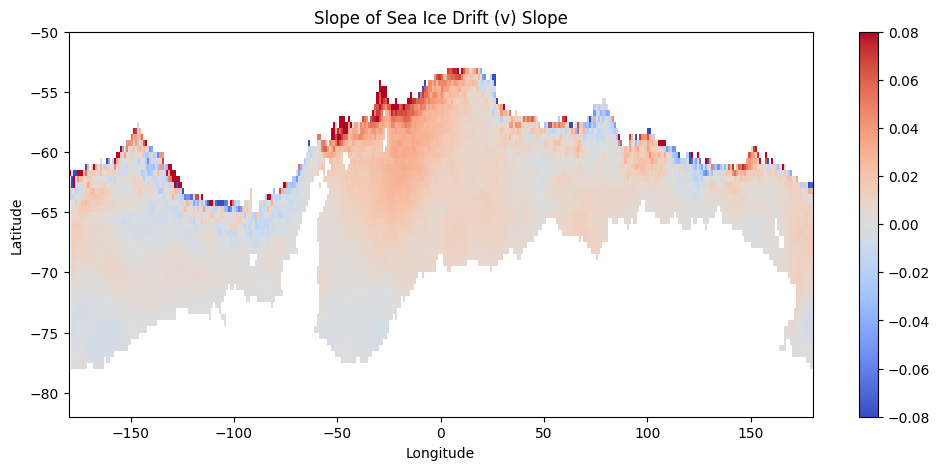

In [272]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope_si_v, vmin=-0.08, vmax=0.08, cmap='coolwarm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Sea Ice Drift (v) Slope')
plt.colorbar()

In [273]:
#DESEASONAL

In [274]:
#deseasonal for sea ice and dot
months = time_dot.astype('datetime64[M]').astype(int) % 12 + 1

In [275]:
# find and remove seasonality from dot_detrended and seaice_detrended
dot_seas = np.zeros((12,dot.shape[1],dot.shape[2])); seaice_seas = np.zeros((12,dot.shape[1],dot.shape[2]))
for m in range(1,13):
    dot_seas[m-1] = np.nanmean(dot_detrended[np.where(months==m)], axis=0)
    seaice_seas[m-1] = np.nanmean(seaice_drift_u_detrended[np.where(months==m)], axis=0)


# remove seasonality from dot and sea ice concetration
dot_final = np.zeros(dot_detrended.shape); seaice_final = np.zeros(seaice_drift_u_detrended.shape)
for i,m in enumerate(months):
    dot_final[i] = dot_detrended[i] - dot_seas[m-1]
    seaice_final[i] = seaice_drift_u_detrended[i] - seaice_seas[m-1]

In [276]:
print("dot_detrended shape:", dot_detrended.shape)
print("seaice_detrended shape:", seaice_drift_u_detrended.shape)
print("months shape:", months.shape)


dot_detrended shape: (196, 64, 360)
seaice_detrended shape: (196, 64, 360)
months shape: (196,)


In [277]:
# find and remove seasonality from U_detrended and sid_curl_detrended
U_seas = np.zeros((12,U.shape[1],U.shape[2])); sid_curl_seas = np.zeros((12,sid_curl.shape[1],sid_curl.shape[2]))
for m in range(1,13):
    U_seas[m-1] = np.nanmean(U_detrended[np.where(months==m)], axis=0)
    sid_curl_seas[m-1] = np.nanmean(sid_curl_detrended[np.where(months==m)], axis=0)

# remove seasonality from U and sea ice drift curl
U_final = np.zeros(U_detrended.shape); sid_curl_final = np.zeros(sid_curl_detrended.shape)
for i,m in enumerate(months):
    U_final[i] = U_detrended[i] - U_seas[m-1]
    sid_curl_final[i] = sid_curl_detrended[i] - sid_curl_seas[m-1]


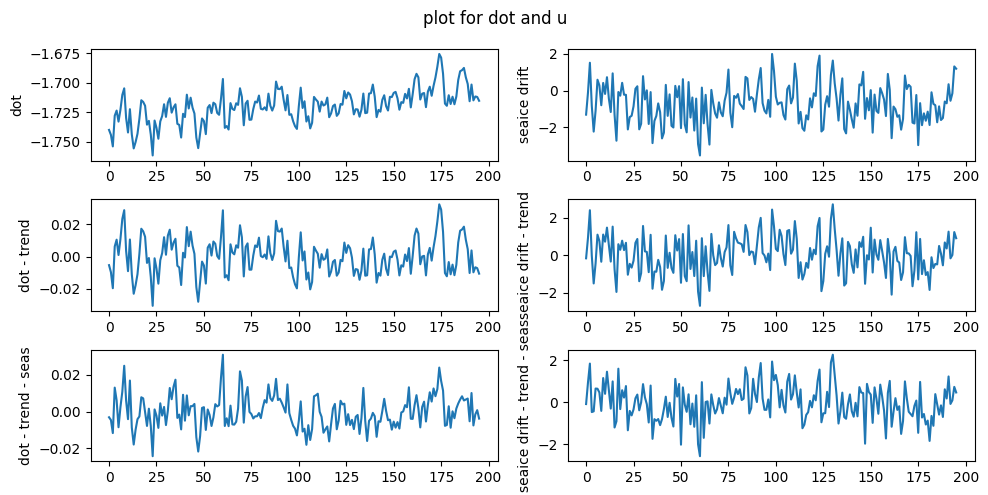

In [278]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
#plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.plot(np.nanmean(regridded_seaice_ds['seaice_drift_u'], axis=(1,2)))
#plt.ylabel('seaice conc')
plt.ylabel('seaice drift')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
# plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.plot(np.nanmean(seaice_drift_u_detrended, axis=(1,2)))
#plt.ylabel('seaice conc - trend')
plt.ylabel('seaice drift - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(seaice_final, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('seaice drift - trend - seas')
plt.suptitle(f"plot for dot and u" )

plt.tight_layout()

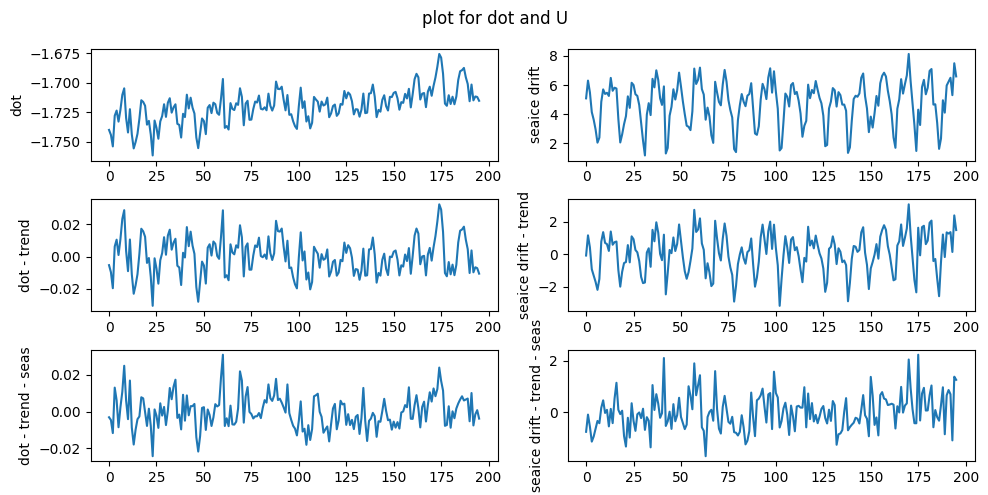

In [279]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
#plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.plot(np.nanmean(U, axis=(1,2)))
#plt.ylabel('seaice conc')
plt.ylabel('seaice drift')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
# plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.plot(np.nanmean(U_detrended, axis=(1,2)))
#plt.ylabel('seaice conc - trend')
plt.ylabel('seaice drift - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(U_final, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('seaice drift - trend - seas')
plt.suptitle(f"plot for dot and U" )

plt.tight_layout()

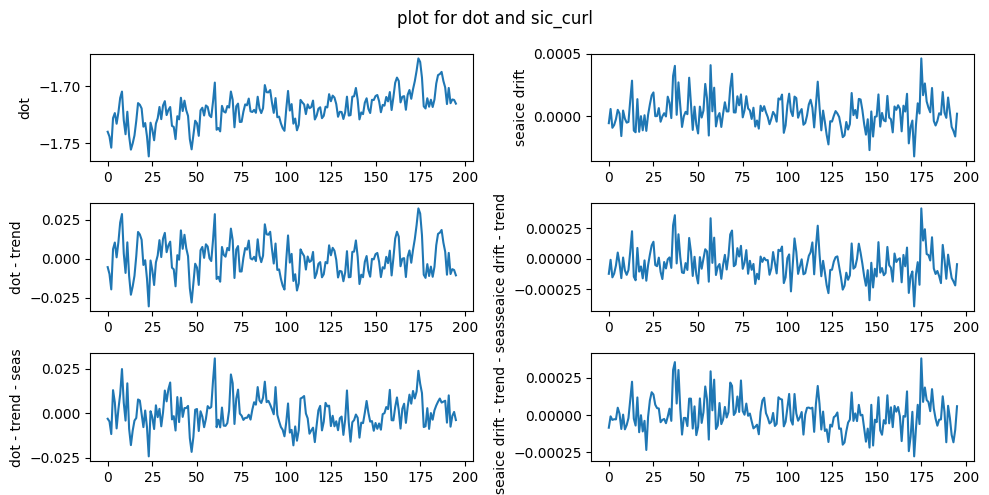

In [280]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
#plt.plot(np.nanmean(regridded_seaice_filtered, axis=(1,2)))
plt.plot(np.nanmean(sid_curl, axis=(1,2)))
#plt.ylabel('seaice conc')
plt.ylabel('seaice drift')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
# plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.plot(np.nanmean(sid_curl_detrended, axis=(1,2)))
#plt.ylabel('seaice conc - trend')
plt.ylabel('seaice drift - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(sid_curl_final, axis=(1,2)))
#plt.ylabel('seaice conc - trend - seas')
plt.ylabel('seaice drift - trend - seas')
plt.suptitle(f"plot for dot and sic_curl" )
plt.tight_layout()


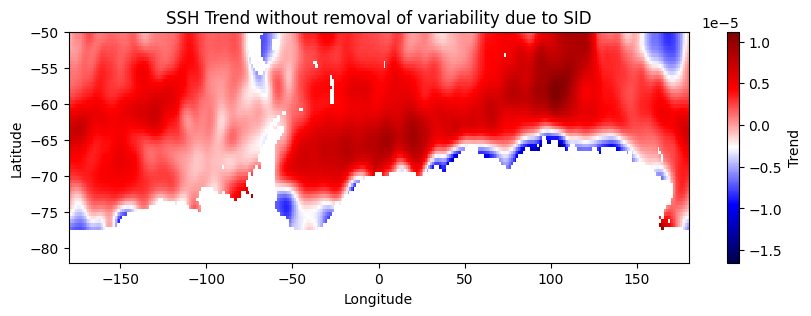

In [281]:
# SSH trends without removing ocean variability due to sea ice concentration
plt.figure(figsize=(10,3))
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot_final)
plt.pcolormesh(lon_mesh, lat_mesh, slope, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SSH Trend without removal of variability due to SID')
cbar = plt.colorbar()
cbar.set_label('Trend')

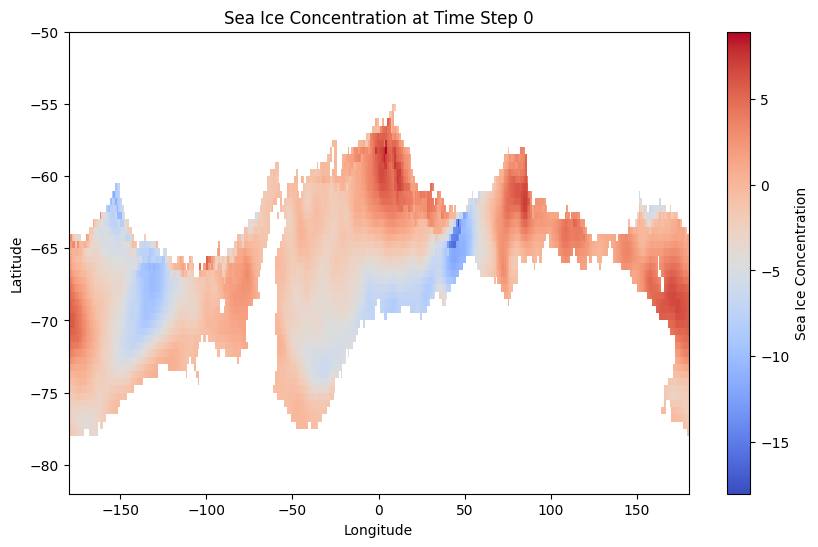

In [282]:
time_step = 0  # You can change this to any index from 0 to 195 (since the shape is (196, 64, 360))

# Extract and plot the masked data for the selected time step
seaice_at_t = regridded_seaice_ds['seaice_drift_u'].isel(time = time_step)


# Plot the data using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh( lon_mesh, lat_mesh,seaice_at_t, cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.title(f"Sea Ice Concentration at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [283]:
# MCA

In [284]:
#MCA of dot, seaice conc, U, sea ice drift

dot_xa = xr.DataArray(dot_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)
seaice_xa = xr.DataArray(seaice_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)
U_xa = xr.DataArray(U_final, coords= [time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)
sid_curl_xa = xr.DataArray(sid_curl_final, coords= [time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)

# print(dot_xa.values)
# print('/n---/n')
# print(seaice_xa.values)

min_value = seaice_xa.where(~seaice_xa.isnull()).min().item()
max_value = seaice_xa.where(~seaice_xa.isnull()).max().item()
print(f"Range of values (excluding NaN): Min = {min_value}, Max = {max_value}")


Range of values (excluding NaN): Min = -22.565124062555537, Max = 20.700299837734562


In [285]:
total_nans = dot_xa.isnull().sum().item()
print(f"Total NaN values in dot_xa: {total_nans}")

total_nans_seaice = seaice_xa.isnull().sum().item()
print(f"Total NaN values in seaice_xa: {total_nans_seaice}")

total_points_dot = dot_xa.size
print(f"Total data points in dot_xa: {total_points_dot}")

total_points_seaice = seaice_xa.size
print(f"Total data points in seaice_xa: {total_points_seaice}")

print(seaice_xa.shape)
print(dot_xa.shape)



Total NaN values in dot_xa: 1582308
Total NaN values in seaice_xa: 3552781
Total data points in dot_xa: 4515840
Total data points in seaice_xa: 4515840
(196, 64, 360)
(196, 64, 360)


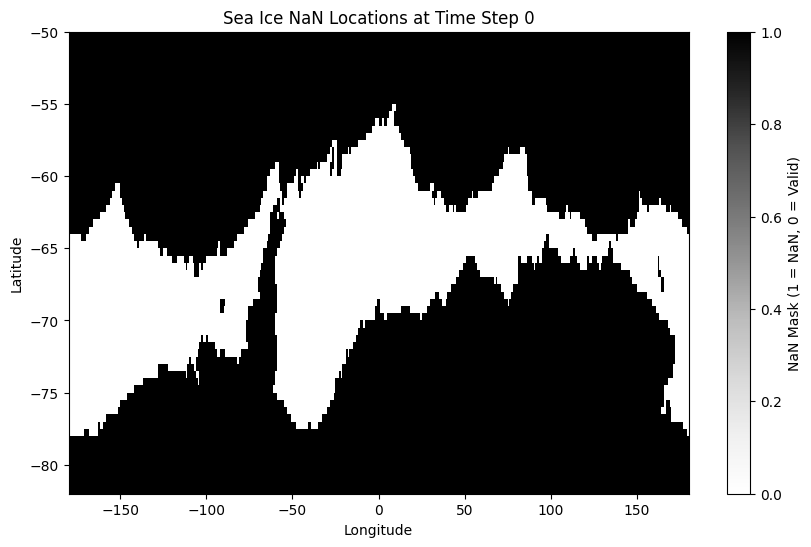

In [286]:
#plot where there are nan values (this is where i created the mask for SIC > 1 earlier)

## NOT SURE I NEED THIS!!!!!

time_step = 0
# Create a mask where NaN values are True
# seaice_nan_mask = np.isnan(regridded_seaice_filtered[time_step])
seaice_nan_mask = np.isnan(regridded_seaice_ds['seaice_drift_u'].isel(time =time_step))

# Plot the mask using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    lon_mesh, lat_mesh, seaice_nan_mask,
    cmap='Greys', shading='auto'
)
plt.colorbar(label='NaN Mask (1 = NaN, 0 = Valid)')
plt.title(f"Sea Ice NaN Locations at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [287]:
print(dir(xe))

['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [288]:
#set all NaN values to = 0 in dot and seaice. this means there has been no change
dot_xa_masked = dot_xa.fillna(0)
seaice_xa_masked = seaice_xa.fillna(0)
sid_curl_xa_masked = sid_curl_xa.fillna(0)
U_xa_masked = U_xa.fillna(0)

print("Masked dot_xa shape:", dot_xa_masked.shape)
print("Masked seaice_xa shape:", seaice_xa_masked.shape)

Masked dot_xa shape: (196, 64, 360)
Masked seaice_xa shape: (196, 64, 360)


In [289]:
print("Remaining NaNs in dot_xa_masked:", dot_xa_masked.isnull().sum().item())
print("Remaining NaNs in seaice_xa_masked:", seaice_xa_masked.isnull().sum().item())


Remaining NaNs in dot_xa_masked: 0
Remaining NaNs in seaice_xa_masked: 0


In [290]:
print(dir(xe))


['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [291]:
import inspect
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(seaice_xa_masked.coords)

model.fit(dot_xa_masked, seaice_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5


In [292]:
s1 = scores1.values; s2 = scores2.values
c1 = comps1.values; c2 = comps2.values

In [293]:
print(path)
print(gridtype)

/Users/iw2g24/PycharmProjects/SSH_project/
remapcon


In [294]:
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")

Directory already exists


In [295]:
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_dot_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0,i]}\t{s1[1,i]}\t{s1[2,i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_si_drift_test_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0,i]}\t{s2[1,i]}\t{s2[2,i]}\n')
file.close()

In [296]:
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...

In [297]:
r_pears = []; p_pears = []
r_spear = []; p_spear = []
for m in range(1,5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2)); p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2)); p_spear.append(np.round(p, 2))

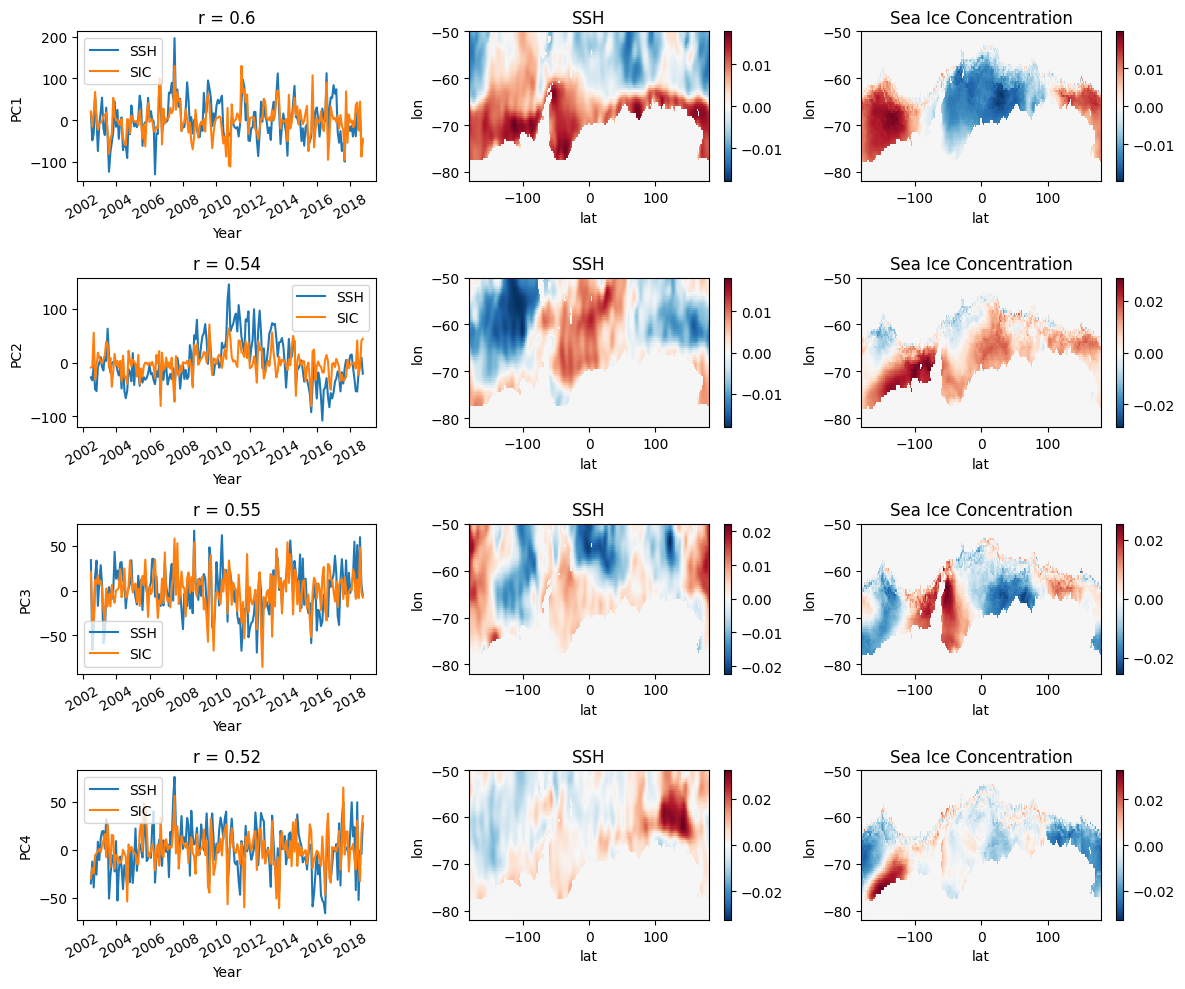

In [298]:
fig = plt.figure(figsize=(12,10))

for i in range(0,4):
    j = 3*i+1 # a = 2*(i+1) + i - 1
    
    plt.subplot(4,3,j)
    scores1.sel(mode=i+1).plot(label = 'SSH')
    scores2.sel(mode=i+1).plot(label = 'SIC')
    plt.title('r = ' +str(r_spear[i]))
    plt.xlabel('Year'); plt.ylabel('PC'+str(int(i+1)))
    plt.xticks(rotation=30) 
    plt.legend()
    
    plt.subplot(4,3,j+1)
    comps1.sel(mode=i+1).plot()
    plt.title('SSH')
    
    plt.subplot(4,3,j+2)
    comps2.sel(mode=i+1).plot()
    plt.title('Sea Ice Concentration')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')

In [299]:
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:',scf)

Cumulative sum of squares: [0.6348105  0.79836528 0.857697   0.88971213 0.91234005 0.92871042
 0.93986857 0.94878807 0.95613412 0.96200368 0.96656647 0.97065539
 0.97422914 0.97744142 0.98030486 0.98254944 0.98464359 0.98614474
 0.98749417 0.98874555 0.9898485  0.9908785 ]
Squared covariance fraction: [0.6348105  0.16355478 0.05933172 0.03201512 0.02262793 0.01637037
 0.01115815 0.0089195  0.00734604 0.00586956 0.0045628  0.00408892
 0.00357375 0.00321228 0.00286345 0.00224458 0.00209415 0.00150115
 0.00134942 0.00125138 0.00110295 0.00103001]


In [300]:
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent =float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i]-cum_sum[i-1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)


<class 'numpy.ndarray'>
22
PCA fraction [0.6348105007668616, 0.1635547828347328, 0.059331719215499734, 0.03201512236350734, 0.022627927106479984, 0.016370370048246707, 0.011158149849993082, 0.008919502291776293, 0.007346042713695766, 0.00586955857472049, 0.00456279572927365, 0.004088916068901716, 0.003573752505382055, 0.0032122751730950805, 0.0028634478597890922, 0.002244580075250857, 0.0020941484499403806, 0.001501151083044272, 0.0013494231461500528, 0.0012513837508573156, 0.0011029457196610748, 0.0010300057608255697]


In [301]:
#HERE I REPEAT THE MCA ANALYSIS FOR U AND SID_CURL !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.52096337 0.70000311 0.76839119 0.82564397 0.86243738 0.88796176
 0.90472118 0.91891529 0.92986033 0.94008799 0.94771392 0.9544256
 0.96019807 0.96477492 0.96929205 0.97311188 0.97599938 0.97832229
 0.980384   0.9823244  0.98415998 0.98570328]
Squared covariance fraction: [0.52096337 0.17903974 0.06838808 0.05725279 0.0367934  0.02552439
 0.01675942 0.01419411 0.01094504 0.01022766 0.00762594 0.

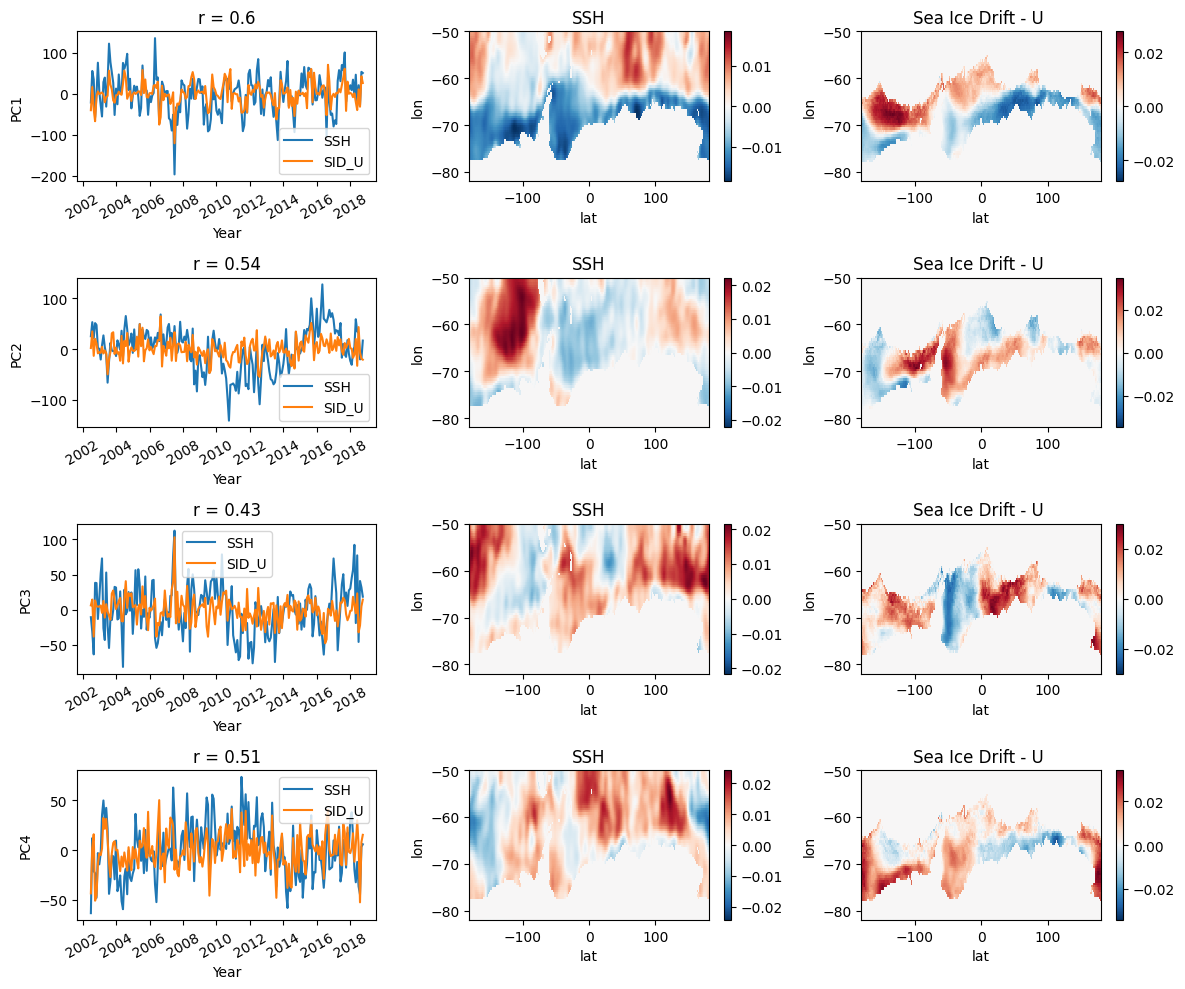

In [302]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(U_xa_masked.coords)

model.fit(dot_xa_masked, U_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_si_drift_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='SID_U')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Sea Ice Drift - U ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)


In [303]:
#HERE I REPEAT THE MCA ANALYSIS FOR SID_CURL vs dot !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.40651744 0.5806814  0.66827189 0.72577337 0.75855254 0.79086721
 0.82035984 0.84405538 0.86251964 0.8784015  0.89204075 0.90343666
 0.9132881  0.92165241 0.92854614 0.93483587 0.94093324 0.94687705
 0.9521184  0.95663925 0.96057577 0.96426264]
Squared covariance fraction: [0.40651744 0.17416395 0.08759049 0.05750148 0.03277917 0.03231467
 0.02949264 0.02369553 0.01846426 0.01588186 0.01363925 0

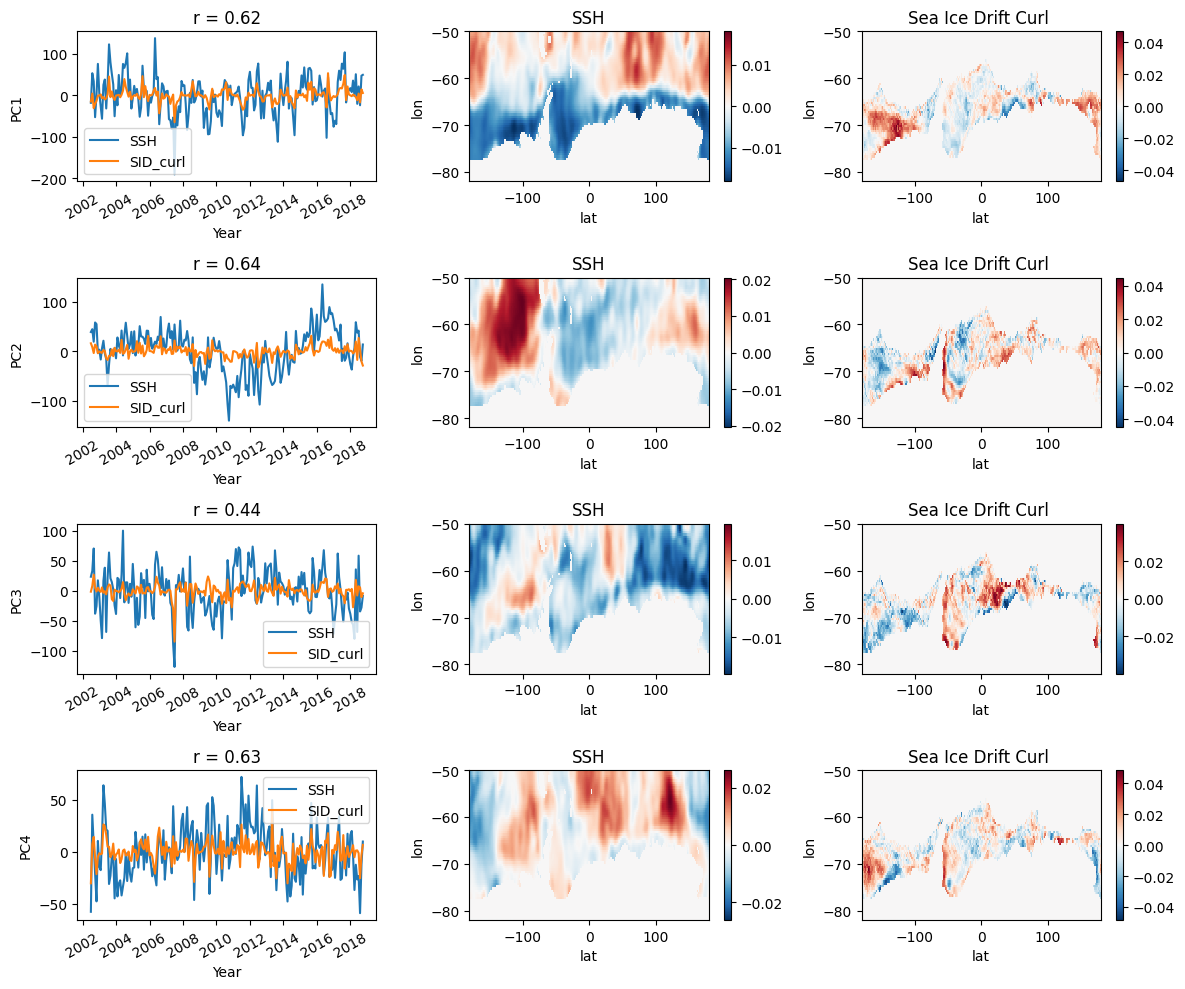

In [304]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(sid_curl_xa_masked.coords)

model.fit(dot_xa_masked, sid_curl_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SSH')
    scores2.sel(mode=i + 1).plot(label='SID_curl')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SSH')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('Sea Ice Drift Curl ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [305]:
#HERE I REPEAT THE MCA ANALYSIS FOR SID_CURL vs SIC !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.48887525 0.61484474 0.69286335 0.76078788 0.80425506 0.83681124
 0.86710453 0.88370654 0.8994486  0.91066167 0.91903918 0.92686718
 0.9334395  0.93948651 0.94482976 0.9500531  0.95466864 0.95873713
 0.96234921 0.96590446 0.96890906 0.97181641]
Squared covariance fraction: [0.48887525 0.12596949 0.07801861 0.06792454 0.04346718 0.03255618
 0.03029329 0.01660201 0.01574206 0.01121306 0.00837751 0

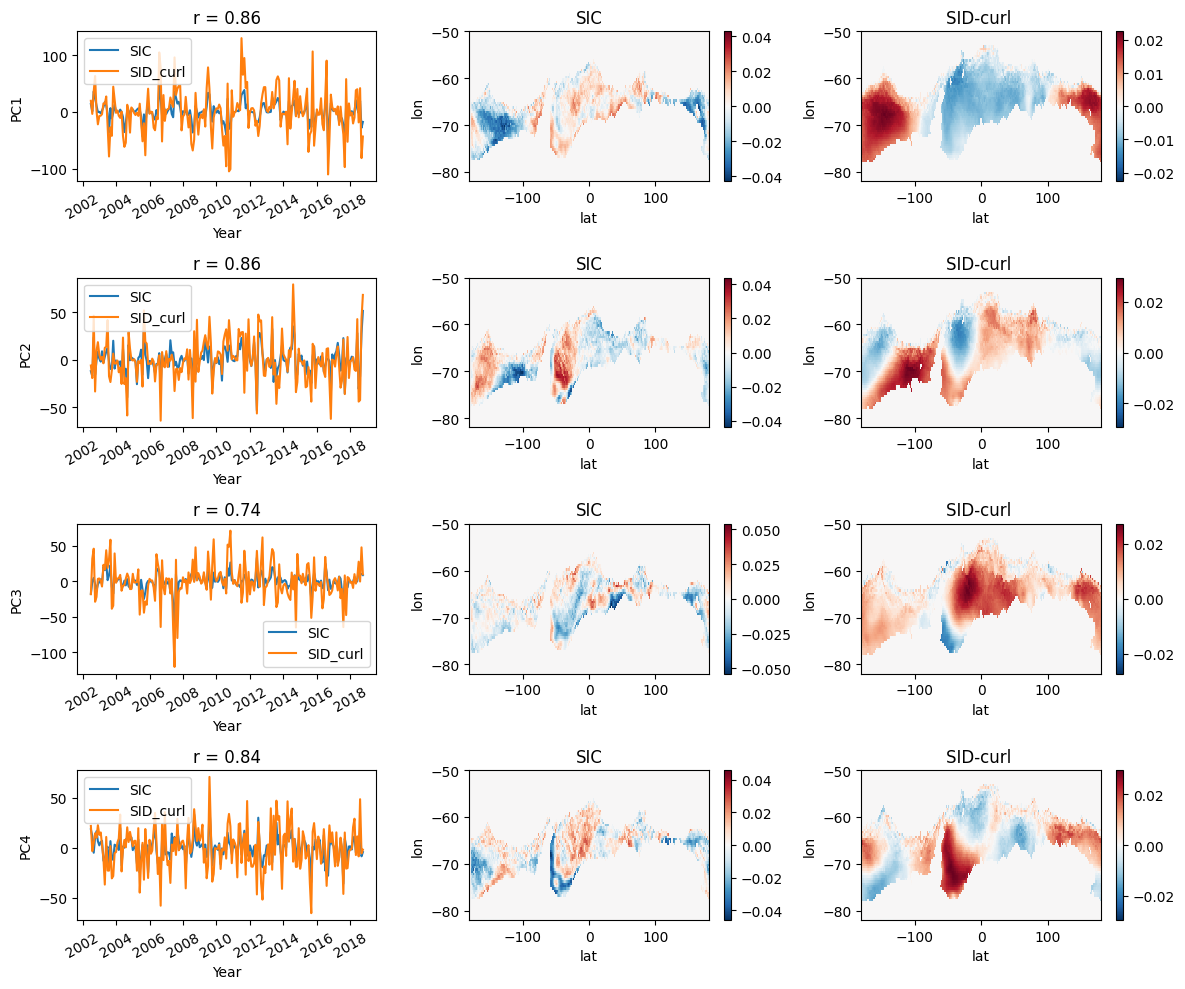

In [306]:
import inspect

model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(sid_curl_xa_masked.coords)
print(seaice_xa_masked.coords)

model.fit(sid_curl_xa_masked, seaice_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_sic_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_sidc_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SIC')
    scores2.sel(mode=i + 1).plot(label='SID_curl')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SIC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('SID-curl ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [307]:
#HERE I REPEAT THE MCA ANALYSIS FOR SID_CURL vs U  !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.34631802 0.47280996 0.59346295 0.68054553 0.7506341  0.78463763
 0.81096651 0.83305892 0.8513839  0.86632276 0.87993326 0.89132783
 0.90202609 0.91133738 0.92043348 0.92796642 0.93502053 0.94170011
 0.94749778 0.95248863 0.95710275 0.96119581]
Squared covariance fraction: [0.34631802 0.12649194 0.12065298 0.08708258 0.07008857 0.03400353
 0.02632888 0.02209241 0.01832498 0.01493886 0.0136105  0

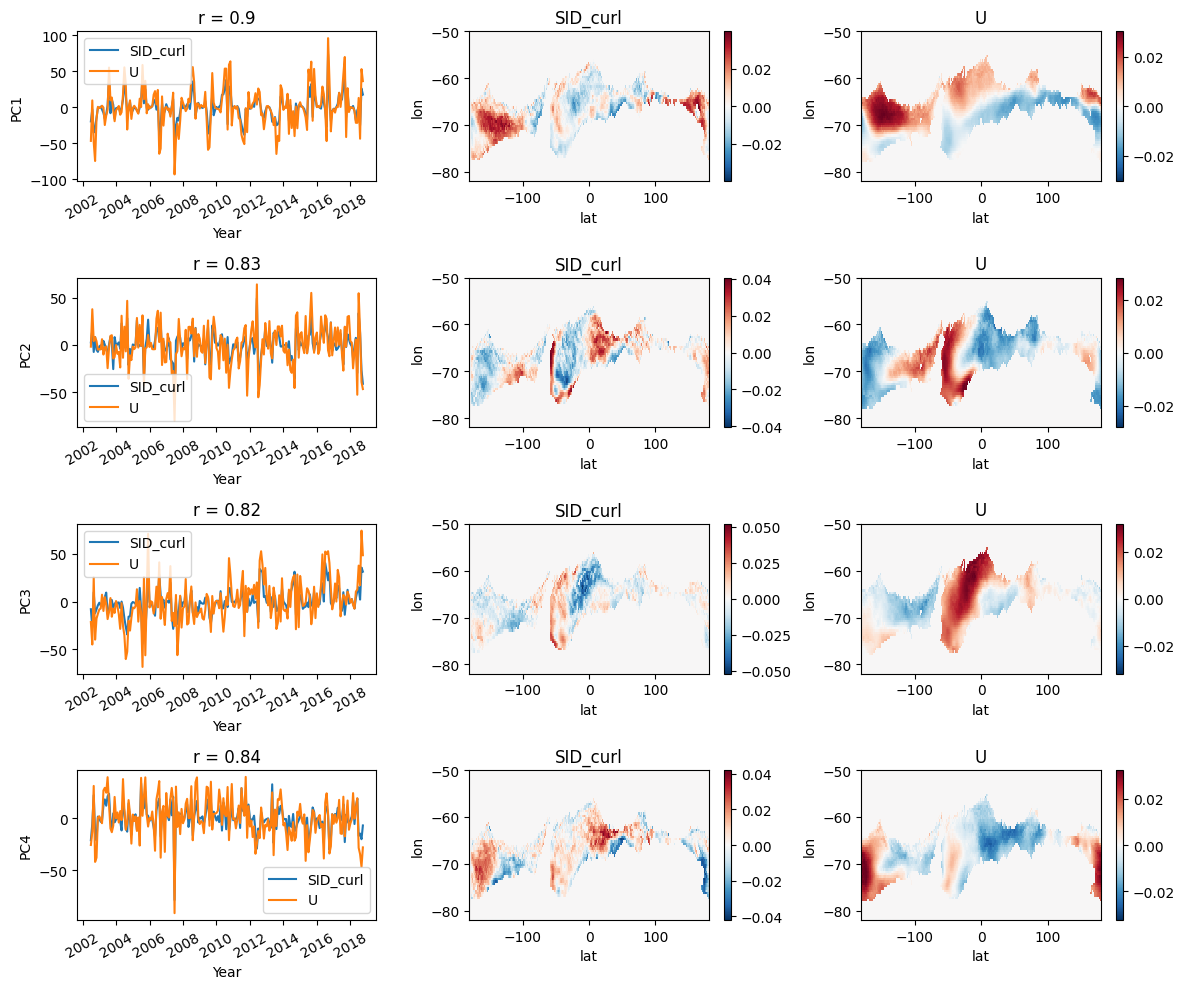

In [308]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(sid_curl_xa_masked.coords)
print(U_xa_masked.coords)

model.fit(sid_curl_xa_masked, U_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sid_curl_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_U_sidc_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SID_curl')
    scores2.sel(mode=i + 1).plot(label='U')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SID_curl')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('U')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)

In [309]:
#HERE I REPEAT THE MCA ANALYSIS FOR SIC vs U  !!!

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
/Users/iw2g24/PycharmProjects/SSH_project/
remapcon
Directory already exists
Cumulative sum of squares: [0.61736588 0.72475517 0.81613172 0.87582553 0.90374232 0.92097798
 0.93354155 0.94384016 0.95256696 0.95783832 0.9625818  0.96691921
 0.97065531 0.97423796 0.97707116 0.97945262 0.98172998 0.98361049
 0.98534467 0.98690308 0.98821778 0.98951974]
Squared covariance fraction: [0.61736588 0.10738929 0.09137655 0.05969381 0.02791679 0.01723565
 0.01256357 0.01029861 0.0087268  0.00527136 0.00474347 0

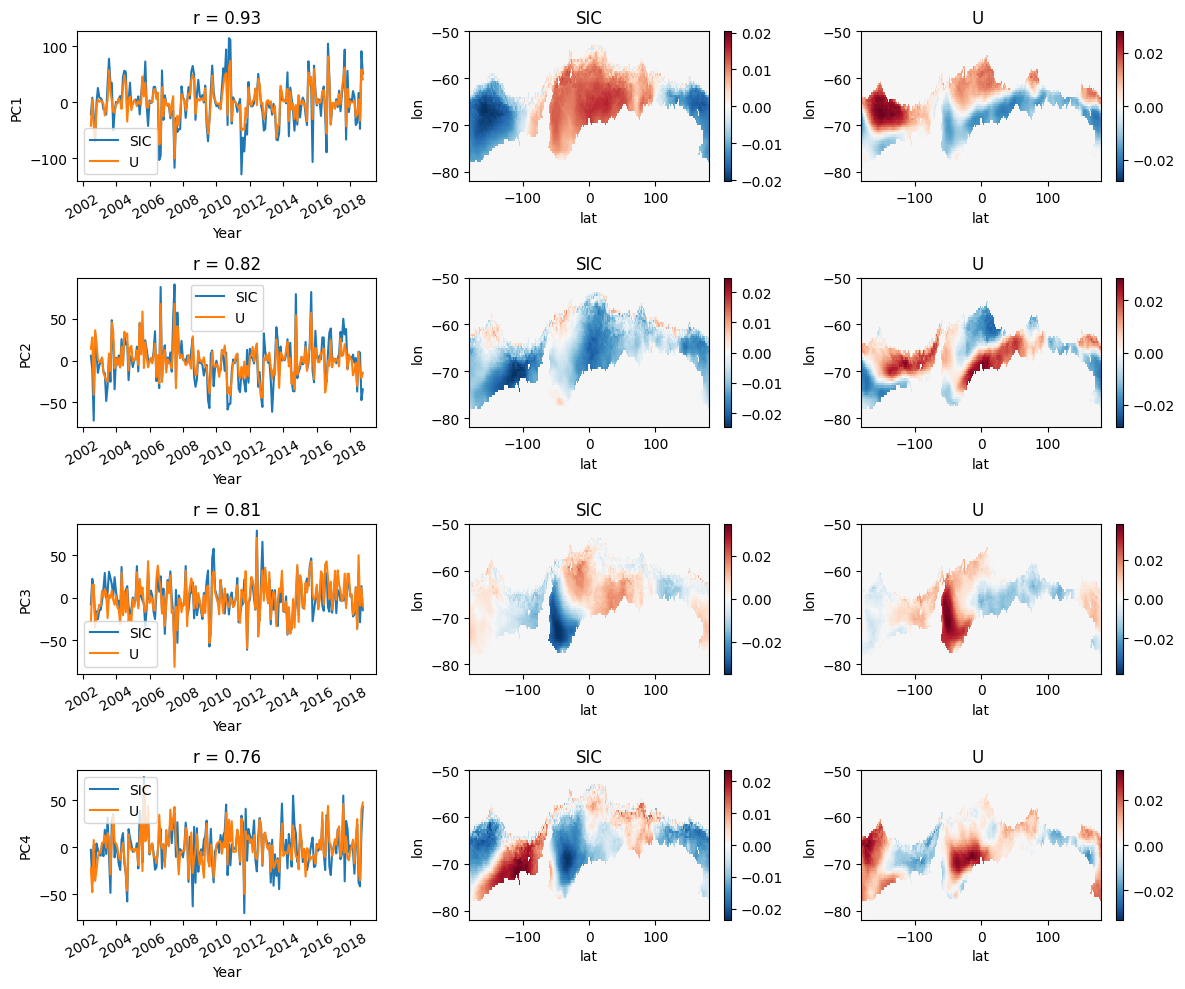

In [310]:
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(seaice_xa_masked.coords)
print(U_xa_masked.coords)

model.fit(seaice_xa_masked, U_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values
print(path)
print(gridtype)
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0, i]}\t{s1[1, i]}\t{s1[2, i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_sic_U_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0, i]}\t{s2[1, i]}\t{s2[2, i]}\n')
file.close()
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))
fig = plt.figure(figsize=(12, 10))

for i in range(0, 4):
    j = 3 * i + 1  # a = 2*(i+1) + i - 1

    plt.subplot(4, 3, j)
    scores1.sel(mode=i + 1).plot(label='SIC')
    scores2.sel(mode=i + 1).plot(label='U')
    plt.title('r = ' + str(r_spear[i]))
    plt.xlabel('Year');
    plt.ylabel('PC' + str(int(i + 1)))
    plt.xticks(rotation=30)
    plt.legend()

    plt.subplot(4, 3, j + 1)
    comps1.sel(mode=i + 1).plot()
    plt.title('SIC')

    plt.subplot(4, 3, j + 2)
    comps2.sel(mode=i + 1).plot()
    plt.title('U ')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:', scf)
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent = float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i] - cum_sum[i - 1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)